In [ ]:
from google.colab import files

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rahulgoel2001","key":"9e29e945e3b5751e8ca33ac9a3f2e0b0"}'}

In [ ]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c digit-recognizer

  0% 0.00/6.09M [00:00<?, ?B/s]
100% 6.09M/6.09M [00:00<00:00, 56.0MB/s]
 55% 5.00M/9.16M [00:01<00:01, 4.31MB/s]
100% 9.16M/9.16M [00:01<00:00, 7.58MB/s]
  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 76.0MB/s]


In [ ]:
!7z x train.csv.zip
!7z x test.csv.zip


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 9606023 bytes (9381 KiB)

Extracting archive: train.csv.zip
--
Path = train.csv.zip
Type = zip
Physical Size = 9606023

  0%     45% - train.csv                 89% - train.csv                Everything is Ok

Size:       76775041
Compressed: 9606023

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 6385593 bytes (6236 KiB)

Extracting archive: test.csv.zip
--
Path = test.csv.zip
Type = zip
Physical Size = 6385593

  0% 

In [ ]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class MNISTDataset(Dataset):
    def __init__(self, csv_path):
        self.data = pd.read_csv(csv_path)
        self.y = torch.tensor(np.asarray(self.data.iloc[:, 0])).long().to('cuda')
        self.X = (torch.tensor((np.asarray(self.data.iloc[:, 1:]) / 255)).float()).to('cuda')
    
    def __getitem__(self, index):
        single_img_label = self.y[index]
        img_as_tensor = self.X[index]
        return (img_as_tensor, single_img_label)
    
    def __len__(self):
        return len(self.data.index)

In [ ]:
data = MNISTDataset("train.csv")

tensor(9, device='cuda:0')


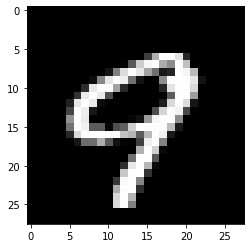

In [ ]:
plt.imshow(data[100][0].view(28, 28).cpu(), cmap = 'gray')
print(data[100][1])

In [ ]:
def make_dataloader(dataset):
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    np.random.seed(42)
    np.random.shuffle(indices)
    split = int(np.floor(dataset_size * 0.2))
    train_indices, valid_indices = indices[split:], indices[:split]
    train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
    valid_sampler = torch.utils.data.SubsetRandomSampler(valid_indices)

    train_loader = DataLoader(dataset, batch_size = 128, sampler = train_sampler)
    valid_loader = DataLoader(dataset, batch_size = 128, sampler = valid_sampler)

    return train_loader, valid_loader

In [ ]:
train_loader, valid_loader = make_dataloader(data)

In [1]:
class FCNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = torch.nn.Linear(784, 500).cuda()
        self.relu1 = torch.nn.ReLU().cuda()
        self.linear2 = torch.nn.Linear(500, 300).cuda()
        self.relu2 = torch.nn.ReLU().cuda()
        self.linear3 = torch.nn.Linear(300, 100).cuda()
        self.relu3 = torch.nn.ReLU().cuda()
        self.linear4 = torch.nn.Linear(100, 50).cuda()
        self.relu4 = torch.nn.ReLU().cuda()
        self.linear5 = torch.nn.Linear(50, 10).cuda()

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.linear1(x)
        x = self.relu1(x)
        x = self.linear2(x)
        x = self.relu2(x)
        x = self.linear3(x)
        x = self.relu3(x)
        x = self.linear4(x)
        x = self.relu4(x)
        x = self.linear5(x)
        return x

NameError: ignored

In [2]:
model = FCNetwork()

NameError: ignored

In [ ]:
optimizer = optim.Adam(model.parameters(), lr = 1e-10, weight_decay=0.1)
loss_func = torch.nn.CrossEntropyLoss()

In [ ]:
def accuracy(outputs, y):
    _, preds = torch.max(outputs, dim = 1)
    return torch.tensor(torch.sum(preds == y).item() / len(preds))

In [ ]:
loss_log = []
accuracy_log = []
val_accuracy_log = []
val_loss_log = []
epochs = 10

In [ ]:
use_cuda = True

In [ ]:
for e in range(epochs):
    trainacc = torch.tensor(0, dtype = torch.float32)
    trainloss = torch.tensor(0, dtype = torch.float32)
    traincnt =  torch.tensor(0, dtype = torch.float32)
    for (i, batch) in enumerate(train_loader):
        traincnt += 1
        X, y = batch
        X, y = Variable(X), Variable(y)
        if use_cuda and torch.cuda.is_available():
            X = X.cuda()
            y = y.cuda()

        optimizer.zero_grad()
        output = model(X)
        loss = loss_func(output, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        acc = accuracy(output, y)

        trainloss += loss
        trainacc += acc
    
    trainloss = trainloss / traincnt
    trainacc = trainacc / traincnt
    loss_log.append(trainloss)
    accuracy_log.append(trainacc)
    
    with torch.no_grad():
        totloss = torch.tensor(0, dtype= torch.float32)
        totacc = torch.tensor(0, dtype = torch.float32)
        cnt = torch.tensor(0, dtype = torch.float32)
        for batch in valid_loader:
            cnt += 1
            X, y = batch
            output = model(X)
            loss = loss_func(output, y)
            totloss += loss
            totacc += accuracy(output, y)
        totloss = totloss / cnt
        totacc = totacc / cnt
        val_loss_log.append(totloss)
        val_accuracy_log.append(totacc)
        print(f"Validation Loss {totloss} Validation Accuracy {totacc} Train Loss {trainloss} Train Accuracy {trainacc}")

In [ ]:
class MNISTDatasetTest(Dataset):
    def __init__(self, csv_path):
        self.data = pd.read_csv(csv_path)
        self.X = (torch.tensor((np.asarray(self.data) / 255)).float()).to('cuda')
    
    def __getitem__(self, index):
        img_as_tensor = self.X[index]
        return img_as_tensor
    
    def __len__(self):
        return len(self.data.index)

In [ ]:
testdata = MNISTDatasetTest("test.csv")

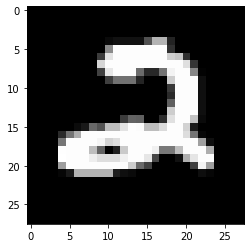

In [ ]:
plt.imshow(testdata[0].view(28, 28).cpu(), cmap = 'gray')

In [ ]:
test_dataloader = DataLoader(testdata, batch_size = 1)

In [ ]:
predictions = []

In [ ]:
for (i, (X)) in enumerate(test_dataloader):
    print(i)
    with torch.no_grad():
        output = model(X)
        _, preds = torch.max(output, dim = 1)
        # print(output[0])
        # print(preds[0])
        predictions.append(preds[0].item())

In [ ]:
indices_list = [i + 1 for i in range(len(predictions))]

In [ ]:
for i in range(10):
    print(predictions.count(i))

2801
3180
2777
2691
2752
2434
2703
2862
2901
2899


In [ ]:
df = pd.DataFrame(data = {"ImageId": indices_list, "Label": predictions})
df.to_csv("submission.csv", index = False)

In [ ]:
files.download("submission.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>